In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle, Circle
from matplotlib import colors, cm
import os

In [2]:
os.chdir("/home/matvey/data/LshCas13a_RNA_cleavage/LshCas13a_in_vitro_total_RNA/")

In [19]:
def build_avelogFC_table(tRNA_positions_df, N5E_aveLogCPMs_df):
    tRNA_tables_list = list()
    for i, row in tRNA_positions_df.iterrows():
        tRNA_start = row["tRNA_start"]
        tRNA_end = row["tRNA_end"]
        tRNA_strand = row["tRNA_strand"]
        tRNA_ACRelPos = row["AC_pos"]

        tRNA_span = np.arange(tRNA_start, tRNA_end+1)

        tRNA_table = N5E_aveLogCPMs_df[(N5E_aveLogCPMs_df["SeqID"] == "NC_000913.3") & 
                                       (N5E_aveLogCPMs_df["Strand"] == tRNA_strand) & 
                                       (N5E_aveLogCPMs_df["Pos"].isin(tRNA_span))]

        tRNA_table["logFC"] = tRNA_table.apply(lambda x: x["T_aveLogCPM"] - x["NT_aveLogCPM"], axis=1)

        if tRNA_strand == "+":
            AC_start_abs = tRNA_start+tRNA_ACRelPos-1
            tRNA_table["ACDist"] = tRNA_table.apply(lambda x: x["Pos"] - AC_start_abs, axis=1)
        elif tRNA_strand == "-":
            AC_start_abs = tRNA_end-tRNA_ACRelPos+1
            tRNA_table["ACDist"] = tRNA_table.apply(lambda x: AC_start_abs - x["Pos"], axis=1)

        tRNA_tables_list.append(tRNA_table)

    tRNA_tables_list_stacked = pd.concat(tRNA_tables_list)

    mean_logFC_list = list()
    mean_logFC_names = ["ACDist", "aveLogFC"]

    for ACDist in set(tRNA_tables_list_stacked["ACDist"].tolist()):
        aveLogFC = np.mean(tRNA_tables_list_stacked[tRNA_tables_list_stacked["ACDist"] == ACDist]["logFC"].tolist())
        mean_logFC_list.append([ACDist, aveLogFC])

    mean_logFC_df = pd.DataFrame.from_records(mean_logFC_list, columns=mean_logFC_names)
    return(mean_logFC_df)

In [20]:
def draw_tRNA_AC_loop(plot, a, b, R, r, colors_array, labels_array=[], title=""):
    def get_x_coord(a, R, t):
        return(a + R*np.cos(t))

    def get_y_coord(b, R, t):
        return(b + R*np.sin(t))
    
    shift = np.pi/9
    angles_array = [x+shift for x in np.linspace(np.pi/2, 2.5*np.pi, 10)][0:-1]

    x_coords = [get_x_coord(a, R, t=x) for x in angles_array]
    y_coords = [get_y_coord(b, R, t=x) for x in angles_array]
    coords_array = [(x, y) for x, y in zip(x_coords, y_coords)]

    for i, coord in enumerate(coords_array):
        circle = Circle(coord, edgecolor="black", radius=r, facecolor=colors_array[1:-1][i])
        plot.add_patch(circle)

    alpha = np.arcsin(r/R)
    L = 2*R*np.sin(alpha/2)

    for i in range(len(angles_array)-1):
        x1 = get_x_coord(a, R, t=angles_array[i]+alpha)
        y1 = get_y_coord(b, R, t=angles_array[i]+alpha)

        x2 = get_x_coord(a, R, t=angles_array[i+1]-alpha)
        y2 = get_y_coord(b, R, t=angles_array[i+1]-alpha)

        plot.plot((x1, x2), (y1, y2), color="black")

    left_stem_nc_x = x_coords[0]
    left_stem_nc_y = y_coords[0] + 2*r + L

    right_stem_nc_x = x_coords[8]
    right_stem_nc_y = y_coords[8] + 2*r + L

    left_stem_nc_cirle = Circle((left_stem_nc_x, left_stem_nc_y), facecolor=colors_array[0], edgecolor="black", radius=r)
    right_stem_nc_circle = Circle((right_stem_nc_x, right_stem_nc_y), facecolor=colors_array[-1], edgecolor="black", radius=r)

    plot.add_patch(left_stem_nc_cirle)
    plot.add_patch(right_stem_nc_circle)

    left_stem_edge_x1 = x_coords[0]
    left_stem_edge_x2 = x_coords[0]
    left_stem_edge_y1 = y_coords[0] + r
    left_stem_edge_y2 = y_coords[0] + r + L

    right_stem_edge_x1 = x_coords[8]
    right_stem_edge_x2 = x_coords[8]
    right_stem_edge_y1 = y_coords[8] + r
    right_stem_edge_y2 = y_coords[8] + r + L

    plot.plot((left_stem_edge_x1, left_stem_edge_x2), (left_stem_edge_y1, left_stem_edge_y2), color="black")
    plot.plot((right_stem_edge_x1, right_stem_edge_x2), (right_stem_edge_y1, right_stem_edge_y2), color="black")
    
    label_shift = r*1.2
    label_font = 14
    label_kwargs={"ha" : "center", "va" : "center"}
    
#     n5e_label_x = left_stem_nc_x
#     n5e_label_y = left_stem_nc_y + r + label_shift
    
#     n3e_label_x = right_stem_nc_x
#     n3e_label_y = right_stem_nc_y + r + label_shift
    
#     plot.annotate("5'", (n5e_label_x, n5e_label_y), size=label_font, annotation_clip=False, **label_kwargs)
#     plot.annotate("3'", (n3e_label_x, n3e_label_y), size=label_font, annotation_clip=False, **label_kwargs)
    
    if len(labels_array) > 0:
        left_label_x = left_stem_nc_x - r - label_shift
        left_label_y = left_stem_nc_y
        
        right_label_x = right_stem_nc_x + r + label_shift
        right_label_y = right_stem_nc_y
        
        plot.annotate(labels_array[0], 
                      (left_label_x, left_label_y), 
                      size=label_font, **label_kwargs)
        plot.annotate(labels_array[-1], 
                      (right_label_x, right_label_y), 
                      size=label_font, **label_kwargs)
        
        label_x_coords = [get_x_coord(a, R+r+label_shift, t=x) for x in angles_array]
        label_y_coords = [get_y_coord(b, R+r+label_shift, t=x) for x in angles_array]
        label_coords_array = [(x, y) for x, y in zip(label_x_coords, label_y_coords)]
        
        for i, coord in enumerate(label_coords_array):
            #label_angle = angles_array[i]*180/np.pi
            label_angle = 0
            _kwargs = {"ha" : "center", "va" : "center", "rotation" : label_angle}
            plot.annotate(labels_array[1:-1][i], coord, size=label_font, **_kwargs)
    
    plot.spines['top'].set_visible(False)
    plot.spines['right'].set_visible(False)
    plot.spines['bottom'].set_visible(False)
    plot.spines['left'].set_visible(False)
    plot.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plot.set_title(title, size=30, loc="left", weight="bold")
    plot.axis("equal")

In [16]:
tRNA_positions = "Annotations/NC_000913.3_Aragorn_tRNAs_renamed.tsv"

N5E_aveLogCPMs = "Results/Tables/Merged_ends_counts/N5E_T_vs_NT_CPM_normalized.tsv.gz"

tRNA_positions_df = pd.read_csv(tRNA_positions, sep="\t")
N5E_aveLogCPMs_df = pd.read_csv(N5E_aveLogCPMs, sep="\t")

In [21]:
mean_logFC_df = build_avelogFC_table(tRNA_positions_df=tRNA_positions_df, 
                                     N5E_aveLogCPMs_df=N5E_aveLogCPMs_df)

/home/matvey/Soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/matvey/Soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/matvey/Soft/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

In [23]:
def draw_generalized_tRNA_cleavage_plot(mean_logFC_df, filepath, title=""):
    
    figure, ax = plt.subplots(figsize=(15,10))
    
    aveLogFC_values = mean_logFC_df[mean_logFC_df["ACDist"].isin(np.arange(-4, 7))].sort_values(by="ACDist")["aveLogFC"].tolist()
    cmap = cm.Reds
    norm = colors.Normalize(vmin=min(aveLogFC_values), vmax=max(aveLogFC_values))
    colors_array = [cmap(norm(aveLogFC_values[i])) for i in range(len(aveLogFC_values))]

    draw_tRNA_AC_loop(plot=ax, a=0, b=0, R=1, r=0.25, colors_array=colors_array, title=title)

    colorbar_settings = cm.ScalarMappable(norm=norm, cmap=cmap)
    colorbar_settings.set_array(aveLogFC_values)

    cbar = figure.colorbar(colorbar_settings)
    cbar.set_label("average log$_2$FC", size=30)
    cbar.ax.tick_params(labelsize=30)
    
    figure.savefig(filepath, dpi=200)

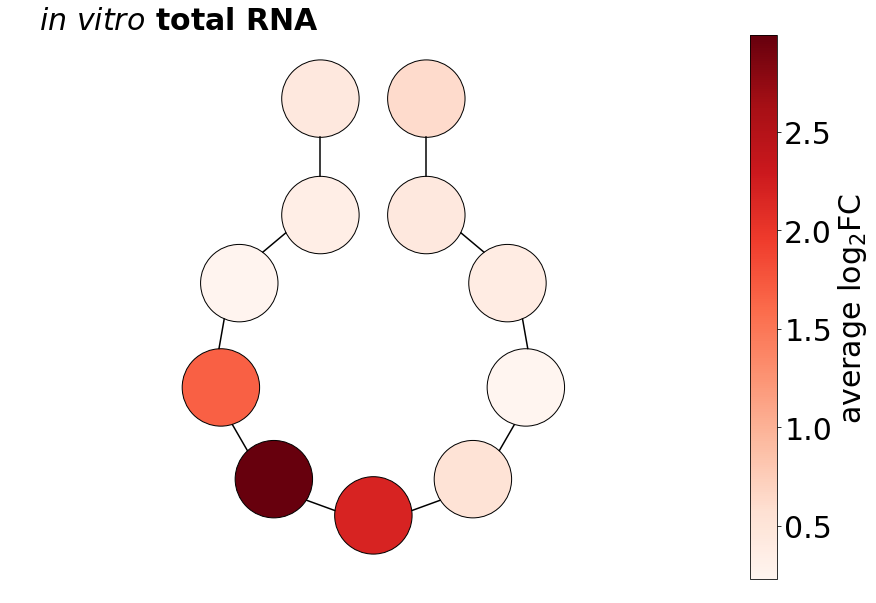

In [26]:
draw_generalized_tRNA_cleavage_plot(mean_logFC_df=mean_logFC_df, 
                                    filepath="Results/Pictures/in_vitro_total_RNA_gen_tRNA_cleavage_heatmap.png",
                                    title="$\it{in\ vitro}$ total RNA")

,ACDist,aveLogFC
0,0,2.990615
